In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import cmb_anomaly_utils as cau

plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('legend', facecolor='white', edgecolor='k', framealpha=1)
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12

#### Run Parameters

In [2]:
max_sim_num                     = 1000
base_path                       = "./output/"
run_inputs  = cau.run_utils.RunInputs()
run_inputs.mask_fpath           = "./input/cmb_fits_files/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
run_inputs.cmb_fpath            = "./input/cmb_fits_files/COM_CMB_IQU-commander_2048_R3.00_full.fits"
run_inputs.cmb_dir_anom_fpath   = "./output/cmb_inpainted_all_dir_cap_anom.txt"
run_inputs.sims_path            = "./input/commander_sims/"
run_inputs.noise_path           = "./input/commander_noise/"
run_inputs.sims_dir_anom_path   = "./output/sims_inpainted_all_dir_cap_anom_5deg/"
run_inputs.geom_flag            = cau.const.CAP_FLAG
run_inputs.measure_flag         = cau.const.STD_FLAG
run_inputs.is_masked            = True
run_inputs.min_pix_ratio        = 0.1
run_inputs.nside                = 64
run_inputs.dir_nside            = 16
run_inputs.geom_start           = 0
run_inputs.geom_stop            = 180
run_inputs.delta_geom_samples   = 1
run_inputs.stripe_thickness     = 20

measure_map_nside               = 16
all_disc_sizes = np.array([4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 40, 45, 50, 55, 60, 70, 75, 80, 85, 90])

#### Compute Measure Map

In [4]:
print("Warming Up!")
map_gen = cau.run_utils.MapGenerator(**run_inputs.to_kwargs())

dummy_map = map_gen.create_dummy_map()
dir_lat, dir_lon = cau.coords.get_healpix_latlon(measure_map_nside)
ndir = cau.coords.get_npix(measure_map_nside)
measure_pix_indices = np.arange(ndir, dtype=int)

cmb_measure = np.zeros(ndir)
sims_measure = np.zeros((max_sim_num, ndir))

print("Reading CMB Data:")
cmb_map = map_gen.create_cmb_map()
cau.map_utils.remove_monopole_dipole(cmb_map)
print("\t-Done-")

print("Providing Simulations:")
sim_maps = []
for sim_num in range(max_sim_num):
    print("\t{:04}/{:04}\r".format(sim_num+1, max_sim_num), end="")
    sim_pix_map = map_gen.create_sim_map_from_txt(sim_num, use_noise=False)
    cau.map_utils.remove_monopole_dipole(sim_pix_map)
    sim_maps.append(sim_pix_map)
print("")

Warming Up!
Reading CMB Data:
	-Done-
Providing Simulations:
	1000/1000


In [ ]:
for disc_size in all_disc_sizes:
    print("Disc Size(deg): {:2}".format(disc_size))
    print("Computing Map Pixels:")
    for dir_i in measure_pix_indices:
        print(f"\t{dir_i}/{ndir - 1}\r", end="")
        plat, plon = dir_lat[dir_i], dir_lon[dir_i]
        dummy_map.change_pole(plat, plon)
        top_filter, bottom_filter = cau.geometry.get_top_bottom_caps_selection_filters( pix_map = dummy_map,
                                                                                        cap_angle = disc_size)
        # CMB measure
        top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(pix_map = cmb_map,
                                                                        top_sel = top_filter,
                                                                        bottom_sel = bottom_filter)
        visible_ratio = top_cap.get_visible_pixels_ratio()
        cmb_measure[dir_i] = \
            np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
        # Simulation Measure
        for sim_num in range(max_sim_num):
            top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(  pix_map = sim_maps[sim_num],
                                                                                top_sel = top_filter,
                                                                                bottom_sel = bottom_filter)
            sims_measure[sim_num, dir_i] = \
                np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                    cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
    print("")

    np.savetxt("./output/akrami_2014/commander_sim_noiseless_var_map_{:02}disc.txt".format(disc_size), sims_measure)
    np.savetxt("./output/akrami_2014/commander_cmb_noiseless_var_map_{:02}disc.txt".format(disc_size), cmb_measure)

# print("-Done-")

#### Fitting Dipole

In [3]:
def get_dipole_amplitude(var_map, mean_field, var_var):
    res = hp.fit_dipole((var_map - mean_field) / var_var)
    amplitude = np.sqrt(np.dot(res[1], res[1]))
    return amplitude

def get_dipole_direction(var_map, mean_field, var_var):
    res = hp.fit_dipole((var_map - mean_field) / var_var)
    direction = hp.vec2ang(res[1], lonlat=True)
    lon, lat = direction[0], direction[1]
    return lat, lon

In [11]:
measure_path = "./output/akrami_2014/"
fnames = os.listdir(measure_path)
sim_fnames = [f_n for f_n in fnames if "sim" in f_n.lower() and "noiseless" in f_n.lower()]
cmb_fnames = [f_n for f_n in fnames if "cmb" in f_n.lower() and "noiseless" in f_n.lower()]

cmb_amplitudes = []
sims_amplitudes = []
for disc_size in all_disc_sizes[:-2]:
    # Read Var Maps
    disc_size_str = str(int(disc_size))
    cmb_f_n = [f_n for f_n in cmb_fnames if disc_size_str in f_n][0]
    cmb_var_map = np.loadtxt(measure_path + cmb_f_n)
    sims_f_n = [f_n for f_n in sim_fnames if disc_size_str in f_n][0]
    all_sims_var_maps = np.loadtxt(measure_path + sims_f_n)
    # Find Mean Field
    mean_field = np.mean(all_sims_var_maps, axis = 0)
    var_var = np.var(all_sims_var_maps, axis = 0)
    # Read Amplitudes
    cmb_amp = get_dipole_amplitude(cmb_var_map, mean_field, var_var)
    cmb_amplitudes.append(cmb_amp)
    sims_amps = [get_dipole_amplitude(sim_var_map, mean_field, var_var) \
                    for sim_var_map in all_sims_var_maps]
    sims_amplitudes.append(sims_amps)

cmb_amplitudes = np.array(cmb_amplitudes)
sims_amplitudes = np.array(sims_amplitudes)

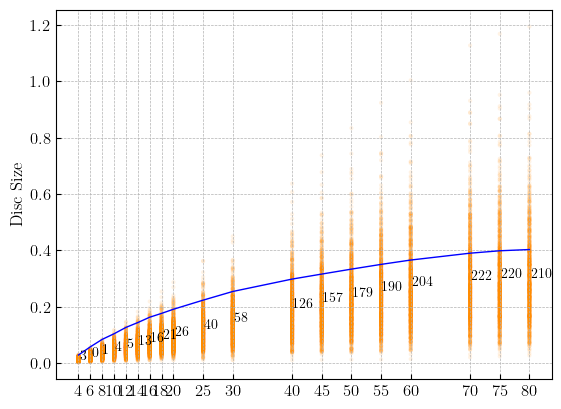

In [12]:
all_p_values = []
with plt.style.context('bmh'):
    fig, ax=plt.subplots()
    for i, disc_size in enumerate(all_disc_sizes[:-2]):
        sims_amps = sims_amplitudes[i]
        p_value = np.sum(sims_amps > cmb_amplitudes[i])# / len(sims_amps)
        all_p_values.append(p_value)
        ax.scatter(
            disc_size * np.ones(max_sim_num), sims_amps,
            marker = '.', edgecolors = 'none', linewidths = 1,
            c = 'darkorange', alpha = 0.1)
        if disc_size == 1:
            ax.text(x=disc_size - 0.5, y = np.mean(sims_amps) + .01, s = str(p_value))
        else:
            ax.text(x=disc_size + 0.2, y = np.mean(sims_amps), s = str(p_value))
    ax.plot(all_disc_sizes[:-2], cmb_amplitudes, color='b', linewidth=1, label = r'CMB')
    ax.set_ylabel(r"Dipole Amplitude")
    ax.set_ylabel(r"Disc Size")
    ax.set_xticks(all_disc_sizes[:-2])
    ax.set_facecolor('white')
    for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
plt.show()

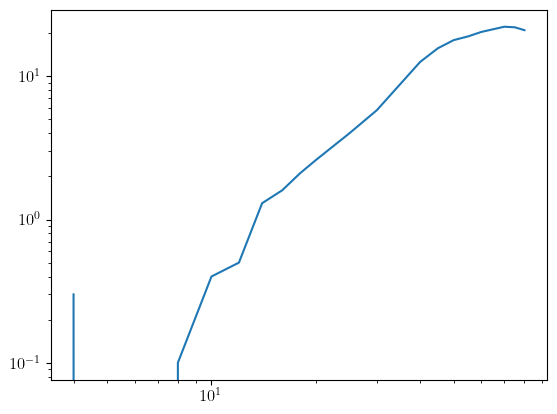

In [13]:
p_values    = np.array(all_p_values)
angles      = all_disc_sizes[:-2]

# for i in range(len(p_values)):

plt.plot(angles, p_values / 1000 * 100)
plt.yscale("log")
plt.xscale("log")
plt.show()

#### Noise check

In [6]:
fnames = os.listdir(run_inputs.noise_path)
for i, f_n in enumerate(fnames):
    noise_map = np.loadtxt(run_inputs.noise_path + f_n)
    hp.mollview(noise_map)
    plt.savefig("./output/plots/noise_check/{:03}.jpg".format(i))


/home/jam3d/.local/lib/python3.10/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


#### Plot

In [17]:
sims_measure = np.loadtxt("./output/akrami_2014/sim_var_map_10disc.txt")
cmb_measure = np.loadtxt("./output/akrami_2014/cmb_var_map_10disc.txt")

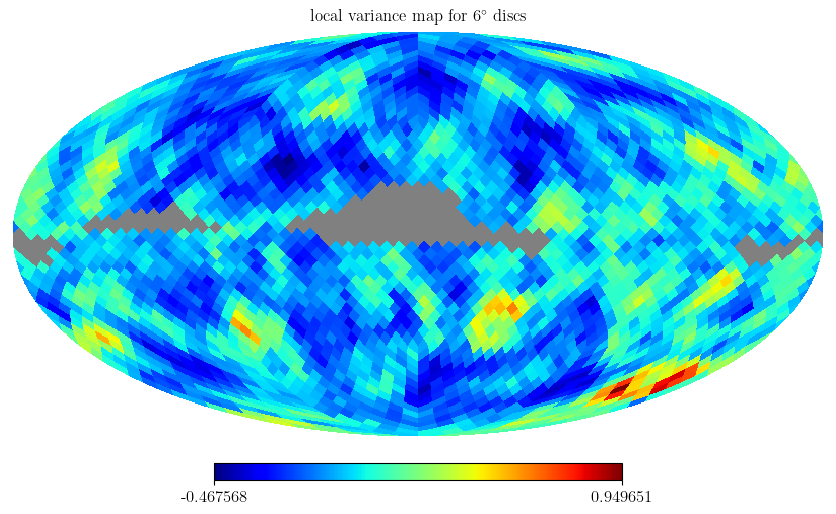

In [18]:
var_var = np.var(sims_measure, axis=0)
mean_var = np.mean(sims_measure, axis=0)
cmb_var = cmb_measure
hp.mollview((cmb_var - mean_var) / var_var,
            # min = -0.5,
            # max = 0.5,
            title = r"local variance map for {}$^\circ$ discs".format(disc_size),
            cmap = "jet")
# hp.mollview((cmb_measure**2 - mean_std**2), cmap="jet")

#### Dipole Amplitude

In [15]:
res = hp.fit_dipole((cmb_var - mean_var)/var_var)
direction = hp.vec2ang(res[1], lonlat=True)
amplitude = np.sqrt(np.dot(res[1], res[1]))
print("Amplitude:", amplitude)
print("Direction(lonlat):", direction[0], direction[1])

Amplitude: 0.05695319162401411
Direction(lonlat): [211.42153332] [-16.20578391]


#### Test Dipole Addition

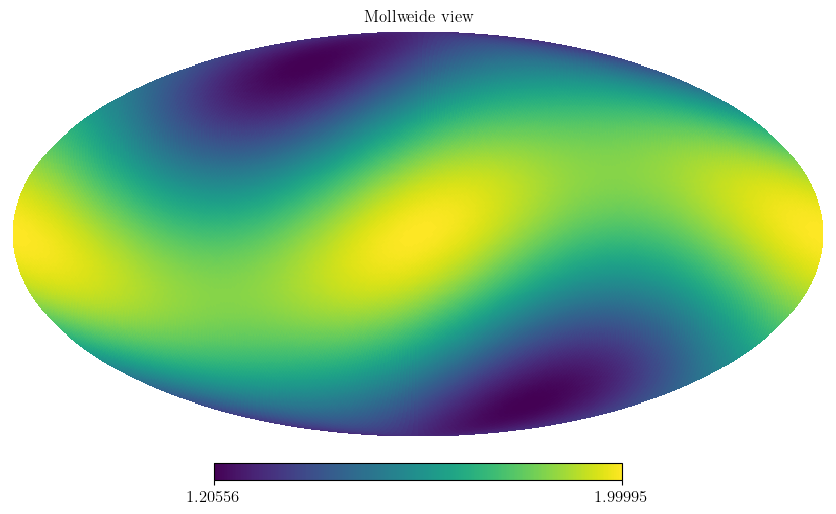

In [80]:
nside = 64
_map = np.zeros(12 * nside * nside)
_pos = cau.coords.get_healpix_xyz(nside)

_map = np.cos(_pos[:, 2])

_map = cau.coords.rotate_pixels_north_to_pole(_map, 45, 90)

hp.mollview(_map + np.cos(_pos[:, 2]))


#### Multipole Checking

nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

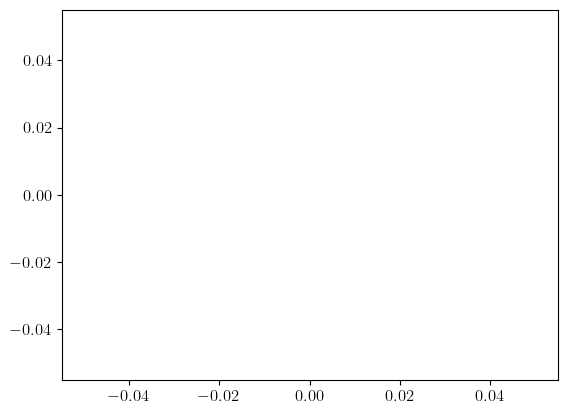

0 nan 
1 nan nan 
2 nan nan nan 
3 nan nan nan nan 
4 nan nan nan nan nan 
5 nan nan nan nan nan nan 
6 nan nan nan nan nan nan nan 
7 nan nan nan nan nan nan nan nan 
8 nan nan nan nan nan nan nan nan nan 
9 nan nan nan nan nan nan nan nan nan nan 
10 nan nan nan nan nan nan nan nan nan nan nan 
11 nan nan nan nan nan nan nan nan nan nan nan nan 
12 nan nan nan nan nan nan nan nan nan nan nan nan nan 
13 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
14 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
15 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
16 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
17 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
18 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
19 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 
20 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 


In [19]:
var_var = np.var(sims_measure, axis=0)
mean_var = np.mean(sims_measure, axis=0)
cmb_var = cmb_measure
lmax = 20
all_cl = hp.anafast((cmb_var - mean_var) / mean_var, lmax=lmax)
for _cl in all_cl:
    print("{:.03}".format(_cl), end=" ")

plt.plot(np.arange(0,lmax + 1)[2:], all_cl[2:])
plt.show()
_alm = hp.map2alm((cmb_var - mean_var) / mean_var, lmax=lmax)
index = 0
for l in range(0, lmax + 1):
    print(l, end=" ")
    same_l_alm = []
    for m in range(0, l + 1):
        elem = _alm[index]
        same_l_alm.append(_alm[index])
        index += 1
        print("{:.05}".format(str(np.absolute(elem))), end=" ")
    print()

#### Legendre fitting along dipole direction

In [ ]:
lmax = 10
_nside = 16
measure_path = "./output/akrami_2014/"
fnames = os.listdir(measure_path)
sim_fnames = [f_n for f_n in fnames if "sim" in f_n.lower() and not "noiseless" in f_n.lower()]
cmb_fnames = [f_n for f_n in fnames if "cmb" in f_n.lower() and not "noiseless" in f_n.lower()]

cmb_amplitudes = []
sims_amplitudes = []
for disc_size in [6]:
    # Read Var Maps
    disc_size_str = str(int(disc_size))
    cmb_f_n = [f_n for f_n in cmb_fnames if disc_size_str in f_n][0]
    cmb_var_map = np.loadtxt(measure_path + cmb_f_n)
    sims_f_n = [f_n for f_n in sim_fnames if disc_size_str in f_n][0]
    all_sims_var_maps = np.loadtxt(measure_path + sims_f_n)
    # Find Mean Field
    mean_field = np.mean(all_sims_var_maps, axis = 0)
    var_var = np.var(all_sims_var_maps, axis = 0)
    
    run_inputs.measure_flag = cau.const.MEAN_FLAG
    _theta = run_inputs.geom_range
    _pos = cau.coords.get_healpix_xyz(nside = _nside)
    # Read Directions and Fit Legendre Polynomials
    dipole_lat, dipole_lon = get_dipole_direction(cmb_var_map, mean_field, var_var)
    cmb_pix_map = cau.dtypes.PixMap((cmb_var_map - mean_field) / var_var, _pos)
    cmb_pix_map.change_pole(dipole_lat, dipole_lon)
    alm = hp.map2alm(cmb_pix_map.raw_data, lmax = lmax)
    cmb_pix_map.raw_data = hp.alm2map(alm, _nside)
    means_of_stripes = cau.measure.get_stripe_measure(cmb_pix_map.raw_data, **run_inputs.to_kwargs())
    cmb_amps = cau.math_utils.get_all_legendre_modulation(_theta, means_of_stripes, lmax)
    cmb_amplitudes = cmb_amps

    for sim_var_map in all_sims_var_maps:
        sim_pix_map = cau.dtypes.PixMap((sim_var_map - mean_field) / var_var, _pos)
        dipole_lat, dipole_lon = get_dipole_direction(sim_var_map, mean_field, var_var)
        sim_pix_map.change_pole(dipole_lat, dipole_lon)
        alm = hp.map2alm(sim_pix_map.raw_data, lmax = lmax)
        sim_pix_map.raw_data = hp.alm2map(alm, _nside)
        means_of_stripes = cau.measure.get_stripe_measure(sim_pix_map.raw_data, **run_inputs.to_kwargs())
        sim_amps = cau.math_utils.get_all_legendre_modulation(_theta, means_of_stripes, lmax)
        sims_amplitudes.append(sim_amps)

cmb_amplitudes = np.array(cmb_amplitudes)
sims_amplitudes = np.array(sims_amplitudes)

In [11]:
cmb_pix_map = cau.dtypes.PixMap((cmb_var_map - mean_field) / var_var, _pos)
hp.map2alm((cmb_var_map - mean_field) / var_var, lmax = 10)

array([nan +0.j, nan +0.j, nan +0.j, nan +0.j, nan +0.j, nan +0.j,
       nan +0.j, nan +0.j, nan +0.j, nan +0.j, nan +0.j, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
       nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj])